In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json
import copy

# init model

In [14]:
config_file = '/mmdetection/checkpoints/origin_crack_cp/copy-paste.py'
checkpoint_file = '/mmdetection/checkpoints/origin_crack_cp/origin_crack_exp_2.pth'

model = init_detector(config_file, checkpoint_file, device='cuda:0')

define path to dataset folder and read testset

In [29]:
path = Path('../data/scratch')

In [30]:
test = json.load(open(path/'annotations'/'test.json'))
print(test['info'])
print(len(test['images']),len(test['annotations']))

{'description': 'Car Parts Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
3775 19453


# read yolo prediction (optional for ensemble anayze result)

In [6]:
total_yolo_bboxes = json.load(open('yolo_old_test_15_7_scratch.json'))

In [18]:
def normolize_box(boxes,height,width):
    new_boxes = []

    for b in boxes:
        new_b = []
        for p in b:
            new_b.extend(np.array(p)/(width,height))
        new_boxes.append(new_b)
    return new_boxes

def get_data_box_ensemble(img,idx,name,boxes,segms,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name

    i_boxes = total_yolo_bboxes[str(idx)]['boxes']
    yolo_boxes = copy.deepcopy(i_boxes)
    h,w = img.shape[:2]
    for j in range(len(yolo_boxes)):
        yolo_boxes[j][0] = int(yolo_boxes[j][0]*w)
        yolo_boxes[j][1] = int(yolo_boxes[j][1]*h)
        yolo_boxes[j][2] = int(yolo_boxes[j][2]*w)
        yolo_boxes[j][3] = int(yolo_boxes[j][3]*h)
        yolo_boxes[j] = [(yolo_boxes[j][0],yolo_boxes[j][1]),(yolo_boxes[j][2],yolo_boxes[j][3])] 

        check_boxes = [0 for i in yolo_boxes]
    check_pred = [0 for i in boxes]
    out_boxes = []
    out_fp_boxes = []
    for i,b in enumerate(boxes):
        ious = [cal_iou(img,b,j) for j,check in zip(yolo_boxes,check_boxes) if check == 0]
        
        if len(ious) == 0:
            break
        max_id = np.argmax(ious)
        
        if ious[max_id] >= 0.25 : 
            out_boxes.append(b)
            check_boxes[max_id] = 1
            check_pred[i] = 1
        else:
            out_fp_boxes.append(b)
            check_pred[i] = -1

    data_box['boxes'] = normolize_box(out_boxes,*img.shape[:-1])
    
    segm_masks = []
    for i,segm in enumerate(segms) :
        #if check_pred[i] == 0: # for fp only
        if check_pred[i] != 1 : 
            continue
        segm = segm.astype(np.uint8)
        contours, _ = cv2.findContours(segm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c.tolist() for c in contours]
        segm_masks.append(contours)
        
    data_box['segms'] = segm_masks
    data_box['labels'] = labels.tolist()

    data_box['scores'] = [float(s) for s,c in zip(scores,check_pred) if c == 1]
    
    return data_box

def get_data_box(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    data_box['boxes'] = normolize_box(boxes,*img.shape[:-1])
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

def get_data_box_flip(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    
    boxes = normolize_box(boxes,*img.shape[:-1])
    for i in range(len(boxes)):
        boxes[i][0] = 1-boxes[i][0]
        boxes[i][2] = 1-boxes[i][2]
    data_box['boxes'] = boxes
    
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

# get result of inference and write into json

In [19]:
output_json_path = 'origin_crack_cp.json'
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.3)
    
    # uncomment if ensemble inference with yolo filter
    #data[i['id']] = get_data_box_ensemble(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    
    #uncoment if single inference
    data[i['id']] = get_data_box(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open(output_json_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

  0%|                                                                                                                                                                        | 0/884 [00:00<?, ?it/s]/mmdetection/mmdet/datasets/utils.py:64: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [02

In [25]:
##
# NOTE : define 'es' (result after inference) before using those visualize function
#
def plot(idx, boxes):
    image = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img = image.copy()
    h,w, _ = img.shape
    for i in range(len(boxes)):
        img = cv2.rectangle(img,(int(boxes[i][0]*w),int(boxes[i][1]*h)),(int(boxes[i][2]*w),int(boxes[i][3]*h)),(255,255,0),2)
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,0,0),2)
    
    plt.figure(figsize=(20,10))
    plt.imshow(np.hstack((img,image)))
    #return np.hstack((img,image))

def plot_fp(idx,i_boxes):
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
    
    pred_labels = [0 for i in boxes]
    
    pred_tp = [0 for i in boxes]
    gt_tp = [0 for i in gt_boxes]
    
    for i in range(len(boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            #print(boxes[i],i_gt_boxes[j])
            iou = cal_iou(img,boxes[i],i_gt_boxes[j])
            if iou > 0.25:
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_labels[idx] = -1
                pred_tp[i] = 1
                gt_tp[idx] = 1
                break
    
    for i in range(len(pred_tp)):
        #print(i)
        #print(boxes[i][0])
        if pred_tp[i]:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2)
        else:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    
    #print(img_out.shape,img.shape)
    return np.hstack((img_out,img))

def plot_fp_v2(idx,i_boxes):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_out = img.copy()
    #print('test : ',es[str(idx)]['image'],es[str(idx)]['scores'])
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth
    check_fp = False
    for i in range(len(boxes)):
        ious = [cal_iou(img,boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        _idx = np.argmax(ious)
        
        if gt_tp[_idx] == 1 :
            continue
        
        if ious[_idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[_idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            check_fp =True
            
#     if len([0 for i in pred_tp if i==1]) == 0 :
#         for i in range(gt_boxes):
#             img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)
#         return np.hstack((img_out,img)),0
    # draw TP, FP, FN
    #print(pred_tp)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for i in range(len(pred_tp)):
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            #print(es[str(idx)]['scores'],i)
            cv2.putText(img_out,"{:.2f}".format(es[str(idx)]['scores'][i]),boxes[i][0], font, 1,(255,255,0),2)
            
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            cv2.putText(img_out,"{:.2f}".format(es[str(idx)]['scores'][i]),boxes[i][0], font, 1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            
    return np.hstack((img_out,img)), check_fp



def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_iou_mask(img,contour1,contour2):
    #print(contour1)
    #print(contour2)
    #print(img.shape[:2])
    mask1 = np.zeros(img.shape[:2])
    mask2 = np.zeros(img.shape[:2])
    #print(mask1.shape,mask2.shape)
    
    mask1 = cv2.fillPoly(mask1,contour1,1)
    mask2 = cv2.fillPoly(mask2,[contour2],1)
    
    plt.imshow(np.hstack([mask1,mask2]))
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())
    #pass

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.25 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_labels[idx] = -1
                break
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

#global check_dense = 0
def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name,check_dense):
    fp = 0
    tp = 0
    fp_boxes = []
    tp_check = [0 for i in pred_boxes]
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0,fp_boxes
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
            tp_check[i] = 1
        else:
            fp += 1
            fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    if len(gt_boxes) >= 8 and tp/len(gt_boxes) > 1:
        check_dense += 1
        
        print('dense cases :',check_dense)
        fp = 0
    
    return tp,fp,fn, fp_boxes,check_dense, tp_check

In [6]:
def plot_fp_v2_with_segm(idx,i_boxes,i_segms):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))

    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    segms = copy.deepcopy(i_segms)
    for i,segm in enumerate(segms):
        segms[i] = [np.array(s).astype(np.int32) for s in segms[i]]
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth

    for i in range(len(boxes)):
        #print([(boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))])
        if len(gt_boxes)==0:
            pred_tp = [-1 for i in boxes]
            break
        ious = [cal_iou_mask(img,segms[i],gt_segms[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)
        
        if gt_tp[idx] == 1 :
            continue
        
        if ious[idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            
    
    # draw TP, FP, FN
    #print(pred_tp)
    for i in range(len(pred_tp)):
        #print(segms[i])
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            img_out = cv2.drawContours(img_out,segms[i],-1,(255,255,0),2)
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            img_out = cv2.drawContours(img_out,segms[i],-1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(255,255,0),2)
        else:
            #print(gt_segms[i])
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(0,0,255),2)
            
    return np.hstack((img_out,img))

# read predict result and compute TP,FP,FN

In [ ]:
es = json.load(open(output_json_path)) 

total_tp = 0
total_fn = 0
total_fp = 0


fp_cases = OrderedDict()
check_dense = 0
count_gt = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_=image.shape
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    count_gt += len(gt_boxes)
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    #gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]    
    #gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_labels = [0 for a in test['annotations'] if a['image_id']==i['id']]
    
    pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
    for j in range(len(pred_boxes)):
        pred_boxes[j][0] = int(pred_boxes[j][0]*w)
        pred_boxes[j][1] = int(pred_boxes[j][1]*h)
        pred_boxes[j][2] = int(pred_boxes[j][2]*w)
        pred_boxes[j][3] = int(pred_boxes[j][3]*h)
        
        pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
    
    #pred_segms = copy.deepcopy(es[str(i['id'])]['segms'])
    #for idx,segm in enumerate(pred_segms):
    #    pred_segms[idx] = [np.array(s).astype(np.int32) for s in pred_segms[idx]]
    
    #print(i['id'])
    #print(es[str(i['id'])])
    pred_labels = es[str(i['id'])]['labels']
    pred_labels = [0 for l in pred_labels]
    
    print(i['id'],i['file_name'])
    old_check = check_dense
    tp,fp,fn, fp_boxes,check_dense, tp_check = cal_v2(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'],old_check)
    #tp,fp,fn, fp_boxes = cal_v2(image,pred_segms,pred_labels,gt_segms,gt_labels, i['file_name'])
    if check_dense - old_check == 1:
        dense_path = Path('dense_scratch')
        dense_path.mkdir(parents=True,exist_ok=True)
        idx = i['id']
        out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
        cv2.imwrite(str(dense_path/(str(idx)+'.jpg')),out)
    es[str(i['id'])]['tp_check'] = tp_check
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if len(fp_boxes) > 0:
        fp_cases[i['file_name']] = fp_boxes
    
    
    print(tp,fp,fn)
    
print(total_tp,total_fp,total_fn,check_dense,count_gt)

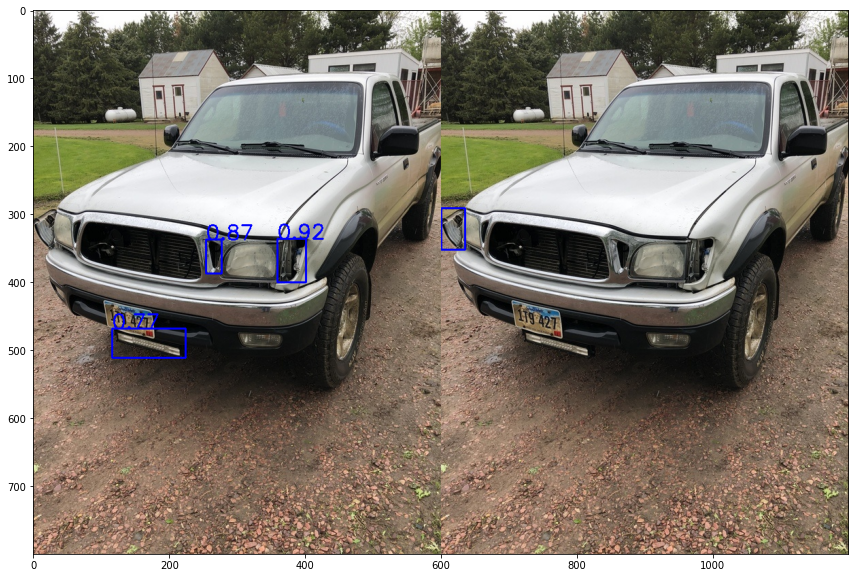

In [28]:
#es = json.load(open(output_json_path)) 
idx = 3432 
i,k = plot_fp_v2(str(idx),es[str(idx)]['boxes'])
#print(i)
plt.figure(figsize=(20,10))
plt.imshow(i)

In [ ]:
# write all predictions to folder

In [26]:
#es = json.load(open(output_json_path))

test_result_path = Path('./origin_crack_result_es')
test_result_path.mkdir(parents=True, exist_ok=True)
for i in tqdm(test['images']):
    idx = i['id']
    out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])

    if out is None:
        continue
    #if out.any() != None : 
    
    #img = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    #im_pil = Image.fromarray(img)
    #im_pil.save(str(test_path)+'/'+str(i['id'])+'.png',optimize=True,quality=70)
    cv2.imwrite(str(test_result_path)+'/'+str(i['id'])+'.png',out)
    #break
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 884/884 [02:33<00:00,  5.77it/s]
